In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import string
import re
import numpy as np
from scipy.stats import lognorm
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import spacy

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Load datasets
traindf = pd.read_csv("train_reviews.csv")
testdf = pd.read_csv("test_reviews.csv")
trainsentences = traindf["Review"].values
trainlabels = traindf["Label"].values
testsentences = testdf["Review"].values
testlabels = testdf["Label"].values

# Load stop words
with open("english", "r") as file:
    stop_words = set(file.read().splitlines())
with open("hotel_names.csv", "r") as file:
    hotel_names = set(file.read().splitlines())

# Preprocessing function with lemmatization
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word not in hotel_names]
    
    # Lemmatize text using spaCy
    doc = nlp(" ".join(words))
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_punct and token.lemma_ not in stop_words and token.lemma_ not in hotel_names])
    
    return lemmatized_text





[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------- -------------------- 6.3/12.8 MB 32.1 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 32.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 28.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
train_sentences_preprocessed = [preprocess_text(sentence) for sentence in trainsentences]
test_sentences_preprocessed = [preprocess_text(sentence) for sentence in testsentences]
train_df_preprocessed = pd.DataFrame({'Review': train_sentences_preprocessed,'Label': trainlabels})
test_df_preprocessed = pd.DataFrame({'Review': test_sentences_preprocessed,'Label': testlabels})

trainsentences = train_df_preprocessed["Review"].values
y_train = train_df_preprocessed["Label"].values

testsentences = test_df_preprocessed["Review"].values
y_test = test_df_preprocessed["Label"].values

# Encode labels as integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# vectorizing
vectorizer = CountVectorizer(ngram_range=(1,1)) # ngram range for specifying unigrams and bigrams (1,1) - unigram, (2,2) - bigram, (1,2) - both
X_train = vectorizer.fit_transform(trainsentences)
X_test = vectorizer.transform(testsentences)

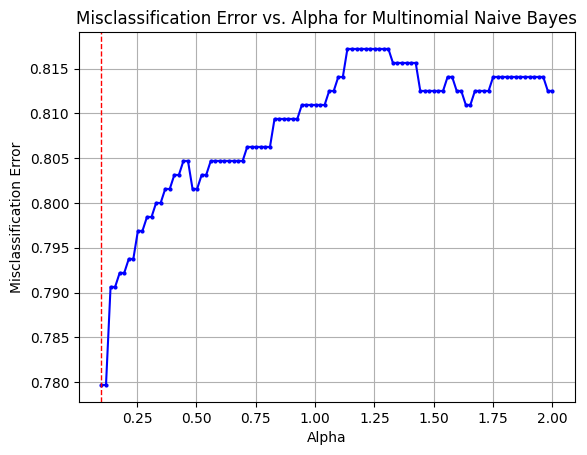

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

# Parameters for grid search
# parameters
param_grid = {
    'alpha': np.linspace(0.1, 2.0, 100),  # Laplace smoothing parameter
    'fit_prior': [True, False]
}
multinomial_naive_bayes = MultinomialNB()

# Set up GridSearchCV
grid_search = GridSearchCV(multinomial_naive_bayes, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
# fit the model
multinomial_naive_bayes = MultinomialNB( alpha =0.1, fit_prior = True)
multinomial_naive_bayes.fit(X_train, y_train)
# predictions
y_pred = multinomial_naive_bayes.predict(X_test)

# Define a custom scoring function for misclassification error
misclassification_scorer = make_scorer(lambda y_true, y_pred: accuracy_score(y_true, y_pred))
# Initialize the Multinomial Naive Bayes classifier
multinomial_naive_bayes = MultinomialNB()

# Define a custom scoring function for misclassification error
misclassification_scorer = make_scorer(lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred))

# Set up GridSearchCV with the misclassification error scoring
grid_search = GridSearchCV(multinomial_naive_bayes, param_grid, cv=5, scoring=misclassification_scorer)
grid_search.fit(X_train, y_train)

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Calculate mean misclassification error for each alpha
alphas = param_grid['alpha']
mean_errors = [1 - score for score in results['mean_test_score'][:len(alphas)]]  # Only first set of results per alpha

# Plotting the misclassification error against alpha values
plt.plot(alphas, mean_errors, marker='o', linestyle='-', color='b',markersize=2)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.title("Misclassification Error vs. Alpha for Multinomial Naive Bayes")
plt.grid(True)
plt.show()


